<a href="https://colab.research.google.com/github/CAP4770-group9-project/final-project/blob/notebook%2Fkmeans/k-means-clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering for Stock Portfolio Diversification

Diversification is a very important step in stock portfolio creation. Picking several stocks rather than just one helps to reduce some of the inherent risk with investing. However, to reap the full benefits of diversification one not only has to pick more than one stock but also ensure that the behaviour of the stocks are not correlated.

This measure of "differentiality" in stock return and variance behavior can be calculated using K means clustering. The stock price data over diffrent periods of time can be put into the clustering algorithm with the goal of clustering the stock based on diffrent behavior. Stocks from these clusters then can be chosen in order to create a well-diversified portfolio.

## Data preprocessing

Now we can import the S&P500 data into Colab

In [130]:
#change directory to where the data is located 
!pwd
%cd drive/My Drive/cap4770-project

/content/drive/My Drive/cap4770-project
[Errno 2] No such file or directory: 'drive/My Drive/cap4770-project'
/content/drive/My Drive/cap4770-project


In [131]:
import pandas as pd
import time

#use timer to get process times
start_time = time.time()

#read csv
data = pd.read_csv("SP_DAILY_2000-2020.csv")
print("read data --- %s seconds ---" % (time.time() - start_time))

availableStocks = data['Symbol'].unique()
print("Number of stocks in the dataset: ", len(availableStocks))
print(data)

read data --- 2.1303634643554688 seconds ---
Number of stocks in the dataset:  503
        Symbol        Date    Open   Close     High     Low    Volume
0          MMM  2020-03-26  131.79  135.98  136.355  130.61   5476351
1          MMM  2020-03-25  133.15  131.54  134.690  126.80   7732467
2          MMM  2020-03-24  122.29  132.72  133.450  121.00   9304832
3          MMM  2020-03-23  128.16  117.87  128.400  114.04   7920348
4          MMM  2020-03-20  138.07  124.89  139.240  122.71   9582251
...        ...         ...     ...     ...      ...     ...       ...
2250258    ZTS  2013-02-07   31.00   32.00   32.730   31.00   3800800
2250259    ZTS  2013-02-06   30.98   31.03   31.430   30.75   2126100
2250260    ZTS  2013-02-05   31.25   31.04   31.980   30.85   5013200
2250261    ZTS  2013-02-04   31.09   31.02   31.990   30.76   7695400
2250262    ZTS  2013-02-01   31.50   31.01   31.740   30.47  66789100

[2250263 rows x 7 columns]


Now we can extract the training data from the dataset

In [132]:
#create DateTime column
stocksData = data

stocksData['DateTime'] = pd.to_datetime(stocksData.apply(lambda row: row['Date'], axis=1))

print(stocksData)

        Symbol        Date    Open  ...     Low    Volume   DateTime
0          MMM  2020-03-26  131.79  ...  130.61   5476351 2020-03-26
1          MMM  2020-03-25  133.15  ...  126.80   7732467 2020-03-25
2          MMM  2020-03-24  122.29  ...  121.00   9304832 2020-03-24
3          MMM  2020-03-23  128.16  ...  114.04   7920348 2020-03-23
4          MMM  2020-03-20  138.07  ...  122.71   9582251 2020-03-20
...        ...         ...     ...  ...     ...       ...        ...
2250258    ZTS  2013-02-07   31.00  ...   31.00   3800800 2013-02-07
2250259    ZTS  2013-02-06   30.98  ...   30.75   2126100 2013-02-06
2250260    ZTS  2013-02-05   31.25  ...   30.85   5013200 2013-02-05
2250261    ZTS  2013-02-04   31.09  ...   30.76   7695400 2013-02-04
2250262    ZTS  2013-02-01   31.50  ...   30.47  66789100 2013-02-01

[2250263 rows x 8 columns]


In [133]:
#get full training data set
trainData = stocksData[(stocksData['DateTime'] > '2010-03-26') & (stocksData['DateTime'] < '2015-03-26')]

#get training data set for 2015
trainData2015 = stocksData[(stocksData['DateTime'] > '2014-03-26') & (stocksData['DateTime'] < '2015-03-26')]
print(trainData2015)

        Symbol        Date    Open   Close     High     Low   Volume   DateTime
1260       MMM  2015-03-25  166.24  162.70  166.520  162.66  2540422 2015-03-25
1261       MMM  2015-03-24  165.58  166.32  167.650  165.53  2090967 2015-03-24
1262       MMM  2015-03-23  166.83  166.13  166.905  165.83  2155702 2015-03-23
1263       MMM  2015-03-20  166.09  166.49  167.134  165.39  4371778 2015-03-20
1264       MMM  2015-03-19  166.16  165.66  166.210  164.85  1953456 2015-03-19
...        ...         ...     ...     ...      ...     ...      ...        ...
2249969    ZTS  2014-04-02   29.28   29.62   29.700   29.14  2341200 2014-04-02
2249970    ZTS  2014-04-01   28.97   29.35   29.390   28.97  3658000 2014-04-01
2249971    ZTS  2014-03-31   29.07   28.94   29.140   28.66  8689200 2014-03-31
2249972    ZTS  2014-03-28   29.46   29.01   29.510   28.91  6398900 2014-03-28
2249973    ZTS  2014-03-27   29.21   29.30   29.395   29.08  2984200 2014-03-27

[120564 rows x 8 columns]


We can perform an initial visualization of the data by plotting

In [0]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
grouped_day_stocks = []
grouped_day = []

#plot all data
#plt.figure()
#for i in range(0, len(availableStocks)):
#  grouped_day_stocks.append(stocksData[stocksData['Symbol'] == availableStocks[i]])
#  grouped_day.append(grouped_day_stocks[i].groupby(lambda x: grouped_day_stocks[i]['DateTime'][x]))
#for j in range(0, len(availableStocks)):
#  plt.plot(grouped_day[j].size().index, grouped_day_stocks[j]['Close'])
#plt.show()

In [0]:
#group day for all training data
grouped_day_stocks = []
grouped_day = []

for i in range(0, len(availableStocks)):
  grouped_day_stocks.append(trainData[trainData['Symbol'] == availableStocks[i]])
  grouped_day.append(grouped_day_stocks[i].groupby(lambda x: grouped_day_stocks[i]['DateTime'][x]))

#print("grouped day stocks")
#print(grouped_day_stocks, "\n")



In [0]:
#print(grouped_day_stocks)

In [0]:
#plot only training data
#plt.figure()
#for j in range(0, len(availableStocks)):
#  plt.plot(grouped_day[j].size().index, grouped_day_stocks[j]['Close'])
#plt.show()

For this 1 year sample of the training data, we can calculate the annualized average returns (based on price at close), annualized average volatility (based on price at close), the average intraday price variation (pct change between daily high and low), average diffrence in price between open and close and annualized trading volume from the data. 

The intraday price variation and diffrence between open and close will be used as additional measures of volatility and hopefully will add richness to the resutls of the k-means analysis

In [0]:
#group day for 2015 data
grouped_day_stocks = []
grouped_day = []

for i in range(0, len(availableStocks)):
  grouped_day_stocks.append(trainData2015[trainData2015['Symbol'] == availableStocks[i]])
  grouped_day.append(grouped_day_stocks[i].groupby(lambda x: grouped_day_stocks[i]['DateTime'][x]))

  

In [140]:
print(len(grouped_day_stocks))

503


###Plotting

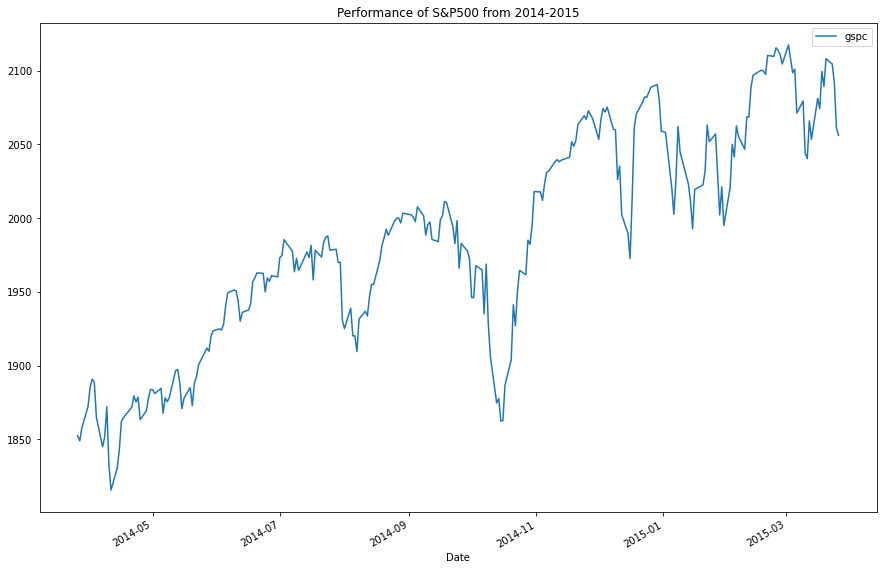

In [141]:
#plot performance of the SP500 over training period

!pip install ffn
import ffn
prices = ffn.get('^GSPC',start='2014-03-26', end='2015-03-26')
ax1 = prices.plot(title="Performance of S&P500 from 2014-2015", figsize=(15, 10))

                gspc
Date                
2014-03-27 -0.001900
2014-03-28  0.004640
2014-03-31  0.007924
2014-04-01  0.007039
2014-04-02  0.002853
...              ...
2015-03-20  0.009013
2015-03-23 -0.001746
2015-03-24 -0.006139
2015-03-25 -0.014559
2015-03-26 -0.002377

[252 rows x 1 columns]
gspc    0.111328
dtype: float64


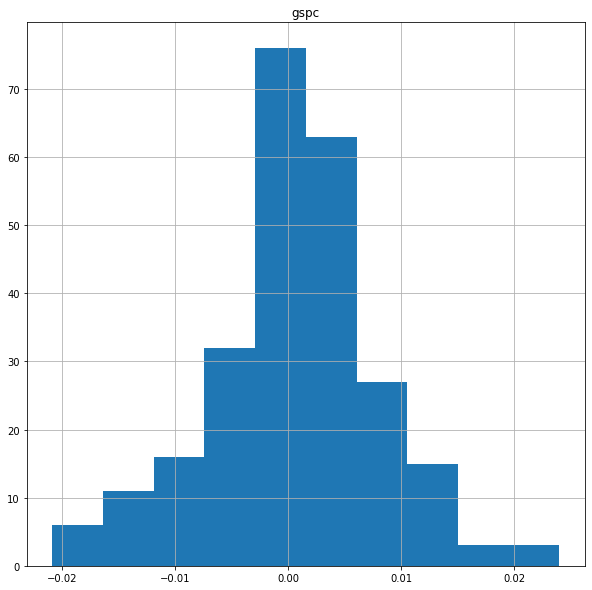

In [142]:
#plot index overall returns
returns = prices.to_returns().dropna()
print(returns)
print(returns.mean() *252)
ax = returns.hist(figsize=(10,10))

In [143]:
"""
Need to rebase price data in order to get a clearer visualization

"""

#plot only training data 2015
#plt.figure()
#for j in range(0, len(availableStocks)):
#  plt.plot(grouped_day[j].size().index, grouped_day_stocks[j]['Close'])
#plt.show()

'\nNeed to rebase price data in order to get a clearer visualization\n\n'

In [144]:
annualized_data = pd.DataFrame(index=availableStocks, columns=['Returns', 'Volatility','Volume', 'HighLowDiff', 'OpenCloseDiff'])

"""
Returns seem to be off a bit, as the sp500 itself has positive average returns but the returns data is negative

"""
#aggregate annualized stock data used in cluserting analysis into dataframe
for i in range(0, len(grouped_day_stocks)):
  
  annualized_data.loc[availableStocks[i]]['Returns'] = grouped_day_stocks[i]['Close'].pct_change().mean() * 252
  annualized_data.loc[availableStocks[i]]['Volatility'] = grouped_day_stocks[i]['Close'].pct_change().std() * 252
  annualized_data.loc[availableStocks[i]]['Volume'] = grouped_day_stocks[i]['Volume'].mean() * 252
  annualized_data.loc[availableStocks[i]]['HighLowDiff'] = ((grouped_day_stocks[i]['High'] - grouped_day_stocks[i]['Low']) / grouped_day_stocks[i]['Low']).mean()
  annualized_data.loc[availableStocks[i]]['OpenCloseDiff'] = ((grouped_day_stocks[i]['Close'] - grouped_day_stocks[i]['Open']) / grouped_day_stocks[i]['Open']).mean()  

print("Annualized data for each stock in S&P500 calculated form 2014 to 2015:")
print(annualized_data)

print("Min/Max statistics: \n")
print("Max returns: ")
print(annualized_data[annualized_data['Returns'] == max(annualized_data['Returns'])], "\n")
print("Min returns: ")
print(annualized_data[annualized_data['Returns'] == min(annualized_data['Returns'])], "\n")

print("Max volatility: ")
print(annualized_data[annualized_data['Volatility'] == max(annualized_data['Volatility'],key=abs)], "\n")
print("Min volatility: ")
print(annualized_data[annualized_data['Volatility'] == min(annualized_data['Volatility'],key=abs)], "\n")

print("Max volume: ")
print(annualized_data[annualized_data['Volume'] == max(annualized_data['Volume'],key=abs)], "\n")
print("Min volume: ")
print(annualized_data[annualized_data['Volume'] == min(annualized_data['Volume'],key=abs)], "\n")

print("Max HighLowDiff: ")
print(annualized_data[annualized_data['HighLowDiff'] == max(annualized_data['HighLowDiff'],key=abs)], "\n")
print("Min HighLowDiff: ")
print(annualized_data[annualized_data['HighLowDiff'] == min(annualized_data['HighLowDiff'],key=abs)], "\n")

print("Max OpenCloseDiff: ")
print(annualized_data[annualized_data['OpenCloseDiff'] == max(annualized_data['OpenCloseDiff'],key=abs)], "\n")
print("Min OpenCloseDiff: ")
print(annualized_data[annualized_data['OpenCloseDiff'] == min(annualized_data['OpenCloseDiff'],key=abs)], "\n")

#

Annualized data for each stock in S&P500 calculated form 2014 to 2015:
        Returns Volatility       Volume HighLowDiff OpenCloseDiff
MMM   -0.192913    2.39916  5.90628e+08   0.0120139   0.000711119
ABT   -0.179184    2.56219  1.33327e+09   0.0146175   0.000502251
ABBV -0.0819894    4.43024  2.60313e+09   0.0221427   0.000568866
ABMD  -0.913676    6.76712  9.48344e+07   0.0307168    0.00185815
ACN  -0.0988941    2.73051  6.90803e+08   0.0140433   0.000706258
...         ...        ...          ...         ...           ...
YUM  -0.0580078    3.26328  7.98818e+08   0.0157174   0.000238743
ZBRA  -0.213887    4.39027  1.31668e+08   0.0230687    0.00090546
ZBH   -0.195326    3.44852  3.14272e+08   0.0162313  -6.55949e-05
ZION   0.143904    3.47235   6.4069e+08   0.0205199  -0.000154421
ZTS   -0.439027    3.25018  9.31993e+08   0.0175066    0.00123164

[503 rows x 5 columns]
Min/Max statistics: 

Max returns: 
      Returns Volatility       Volume HighLowDiff OpenCloseDiff
AAPL  5.50024

For now we will run the K means using only 3 attributes, the mean returns, variance, and volume

In [145]:
#Concatenating the returns and variances and volume into a single data-frame
ret_var_vol = annualized_data.drop(['HighLowDiff','OpenCloseDiff'], axis=1)
print(ret_var_vol)

        Returns Volatility       Volume
MMM   -0.192913    2.39916  5.90628e+08
ABT   -0.179184    2.56219  1.33327e+09
ABBV -0.0819894    4.43024  2.60313e+09
ABMD  -0.913676    6.76712  9.48344e+07
ACN  -0.0988941    2.73051  6.90803e+08
...         ...        ...          ...
YUM  -0.0580078    3.26328  7.98818e+08
ZBRA  -0.213887    4.39027  1.31668e+08
ZBH   -0.195326    3.44852  3.14272e+08
ZION   0.143904    3.47235   6.4069e+08
ZTS   -0.439027    3.25018  9.31993e+08

[503 rows x 3 columns]


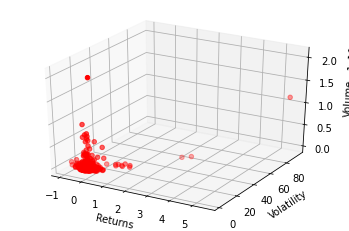

In [146]:
%matplotlib inline
#first plot data to spot outliers
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = list(ret_var_vol['Returns'].dropna().values)
y = list(ret_var_vol['Volatility'].dropna().values)
z = list(ret_var_vol['Volume'].dropna().values)
#print(x, "\n", len(x))
#print(y, "\n", len(y))
#print(z, "\n", len(z))

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('Returns')
ax.set_ylabel('Volatility')
ax.set_zlabel('Volume')

plt.show()

In [0]:
#identify the volatility outlier, drop, then graph again
#2014-2015 volatility outliers 'AAPL', 'V', 'HBI'
#outlier = ret_var_vol['Volatility'] == max(ret_var_vol['Volatility'],key=abs)
#outlierIndex = ret_var_vol[outlier].index
#print(outlierIndex, "\n")

outlierIndex = ['AAPL','V','HBI']
ret_var_vol.drop(outlierIndex, inplace =True)

In [0]:
#code to drop volume outliers
#2014 to 2015 volume outlier 'BAC'
#outlier = ret_var_vol['Volume'] == max(ret_var_vol['Volume'],key=abs)
#outlierIndex = ret_var_vol[outlier].index
#print(outlierIndex, "\n")

outlierIndex = 'BAC'
ret_var_vol.drop(outlierIndex, inplace =True)

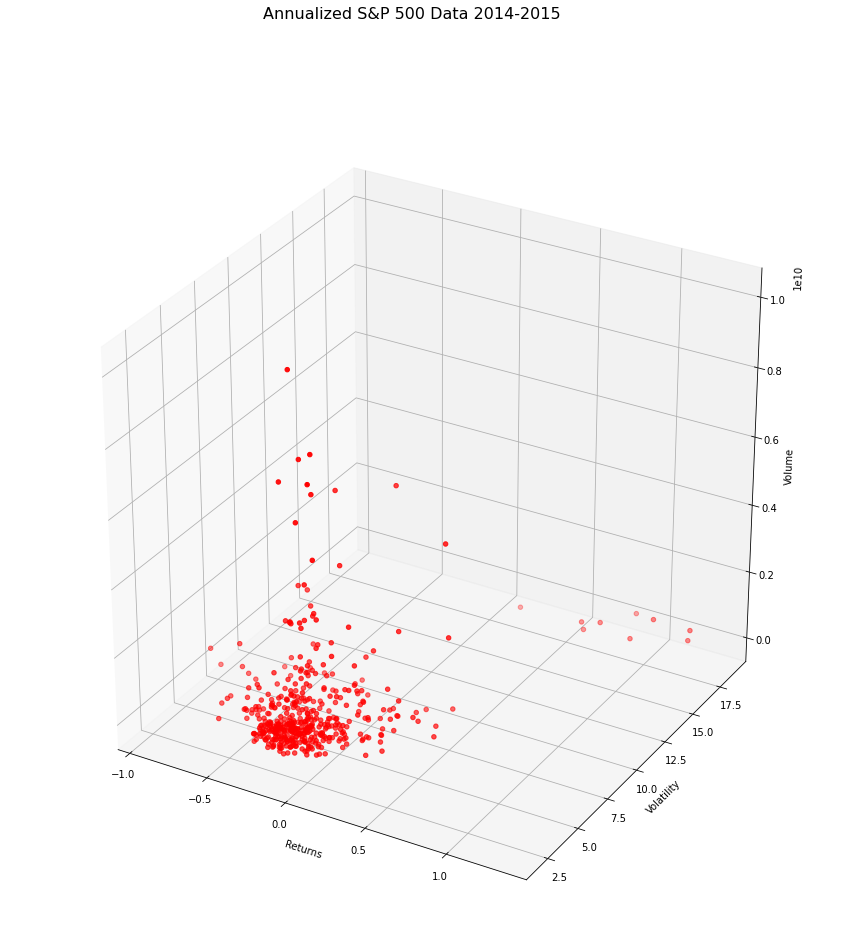

In [149]:
#regraph after outliers are dropped

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle('Annualized S&P 500 Data 2014-2015', fontsize=16)

x = list(ret_var_vol['Returns'].dropna().values)
y = list(ret_var_vol['Volatility'].dropna().values)
z = list(ret_var_vol['Volume'].dropna().values)
#print(x, "\n", len(x))
#print(y, "\n", len(y))
#print(z, "\n", len(z))

ax.scatter(x, y, z, c='r', marker='o')
#ax.title("Annualized S&P500 Data")

ax.set_xlabel('Returns')
ax.set_ylabel('Volatility')
ax.set_zlabel('Volume')

plt.show()

##Clustering Analysis | Returns, Volume, Volatility

In [0]:
#taken from: https://towardsdatascience.com/machine-learning-for-stock-clustering-using-k-means-algorithm-126bc1ace4e1
#https://www.pythonforfinance.net/2018/02/08/stock-clusters-using-k-means-algorithm-in-python/

from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
import numpy as np
from scipy.cluster.vq import kmeans,vq
import pandas as pd
import pandas_datareader as dr
from math import sqrt
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

#format the data as a numpy array to feed into the K-Means algorithm
#X = np.asarray([np.asarray(ret_var_vol['Returns']),np.asarray(ret_var_vol['Volatility']),np.asarray(ret_var_vol['Volume'])]).T
X = ret_var_vol.dropna().values

Text(0.5, 1.0, 'Elbow curve')

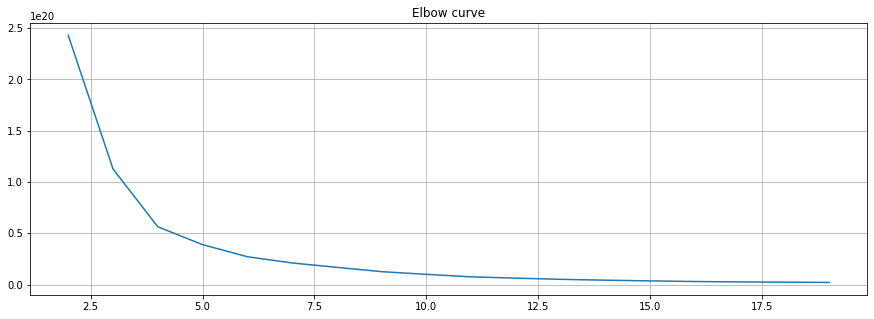

In [151]:
#generate elbow curve
distorsions = []
for k in range(2, 20):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

Now we can undertake in the K-means clustering and plot the results

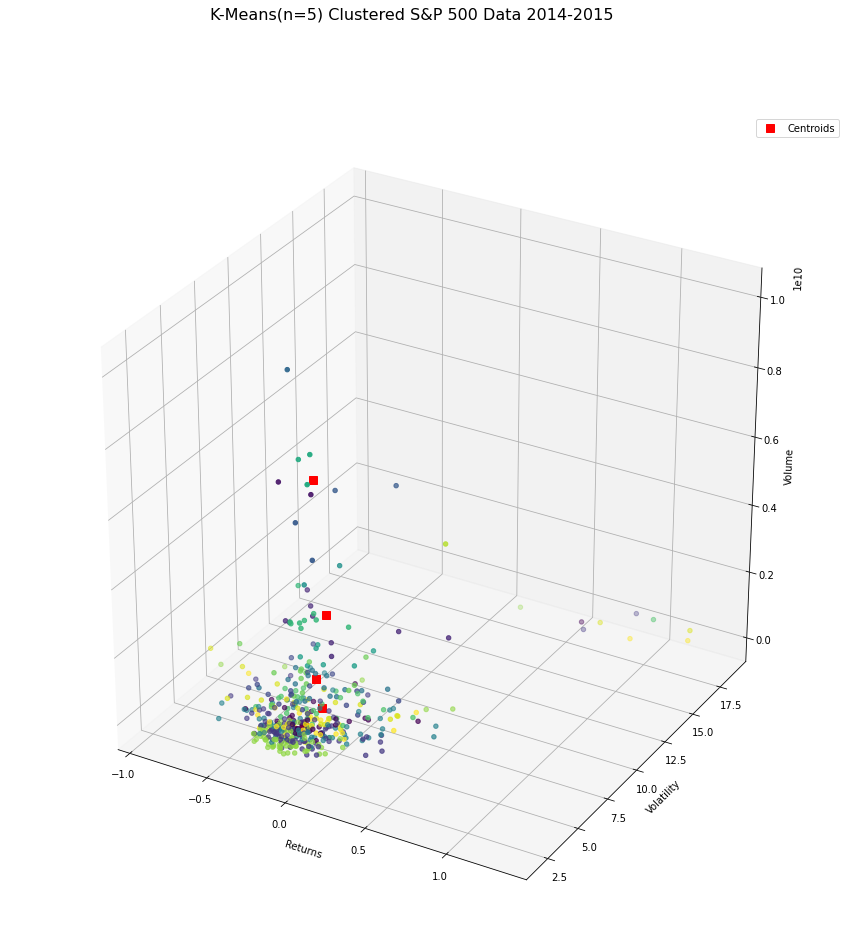

In [152]:
import  pylab as pl

#compute K means with n = 5 and get centroids
kmeans = KMeans(n_clusters = 5)
kmeans.fit(X)
centroids = kmeans.cluster_centers_
#print(centroids)
#print(kmeans.labels_)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle('K-Means(n=5) Clustered S&P 500 Data 2014-2015', fontsize=16)

ax.scatter(x, y, z, c=k_means.labels_, marker='o')
plot(centroids[:,0],centroids[:,1],centroids[:,2],'sr',markersize=8)
ax.legend(['Centroids'])
ax.set_xlabel('Returns')
ax.set_ylabel('Volatility')
ax.set_zlabel('Volume')


plt.show()



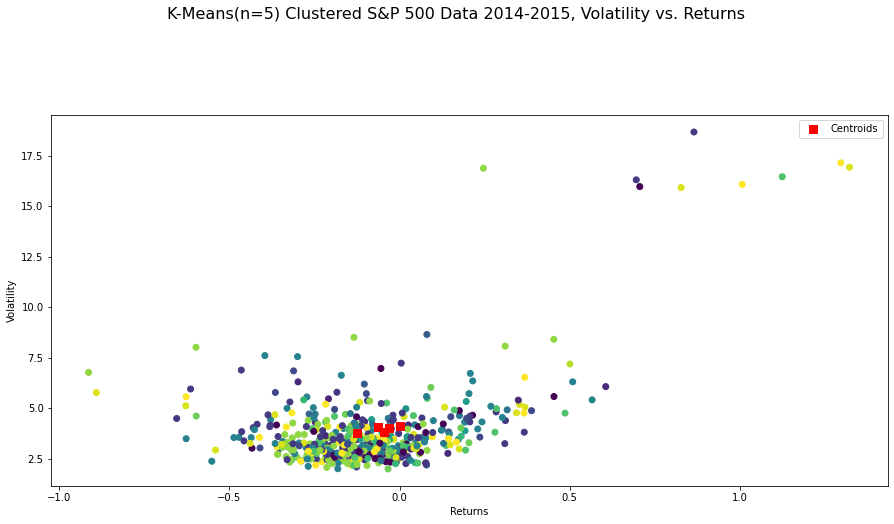

In [153]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('K-Means(n=5) Clustered S&P 500 Data 2014-2015, Volatility vs. Returns', fontsize=16)
ax = fig.add_subplot(2, 1, 1)
ax.scatter(x, y, c=k_means.labels_, marker='o')
plot(centroids[:,0],centroids[:,1], 'sr',markersize=8)
ax.legend(['Centroids'])
ax.set_xlabel('Returns')
ax.set_ylabel('Volatility')


plt.show()

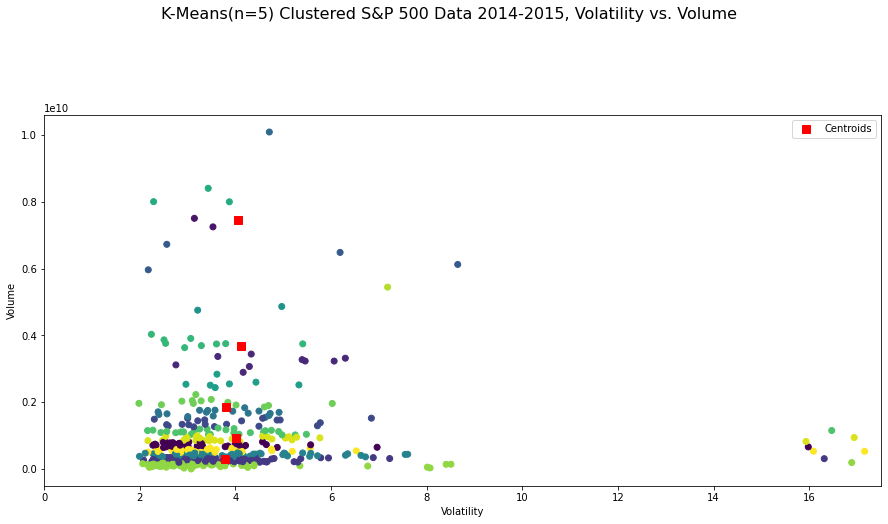

In [154]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('K-Means(n=5) Clustered S&P 500 Data 2014-2015, Volatility vs. Volume', fontsize=16)
ax = fig.add_subplot(2, 1, 1)
ax.scatter(y, z, c=k_means.labels_, marker='o')
plot(centroids[:,1],centroids[:,2], 'sr',markersize=8)
ax.legend(['Centroids'])
ax.set_xlabel('Volatility')
ax.set_ylabel('Volume')
ax.set_xlim(0,17.5)

plt.show()

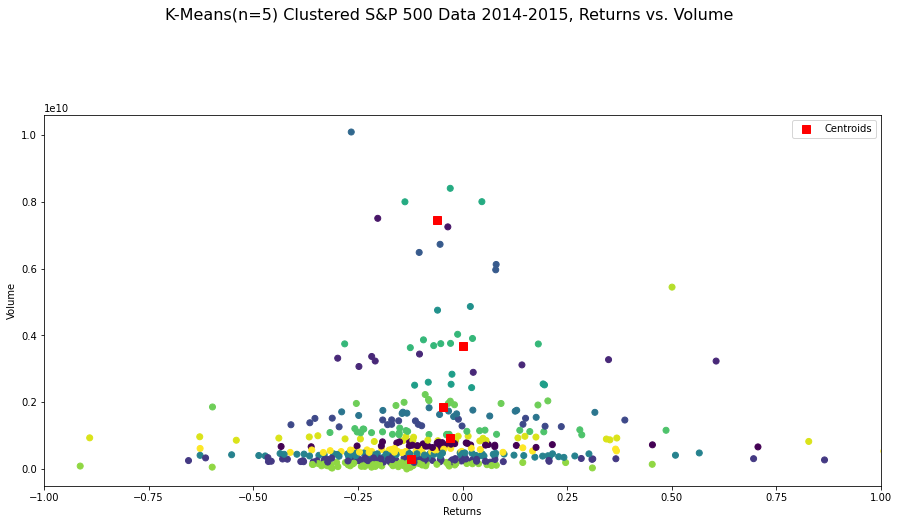

In [155]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('K-Means(n=5) Clustered S&P 500 Data 2014-2015, Returns vs. Volume', fontsize=16)
ax = fig.add_subplot(2, 1, 1)
ax.scatter(x, z, c=k_means.labels_, marker='o')
plot(centroids[:,0],centroids[:,2], 'sr',markersize=8)
ax.legend(['Centroids'])
ax.set_xlabel('Returns')
ax.set_ylabel('Volume')
ax.set_xlim(-1,1)


plt.show()

We try diffrent axes configurations to get additional perspectives of the data

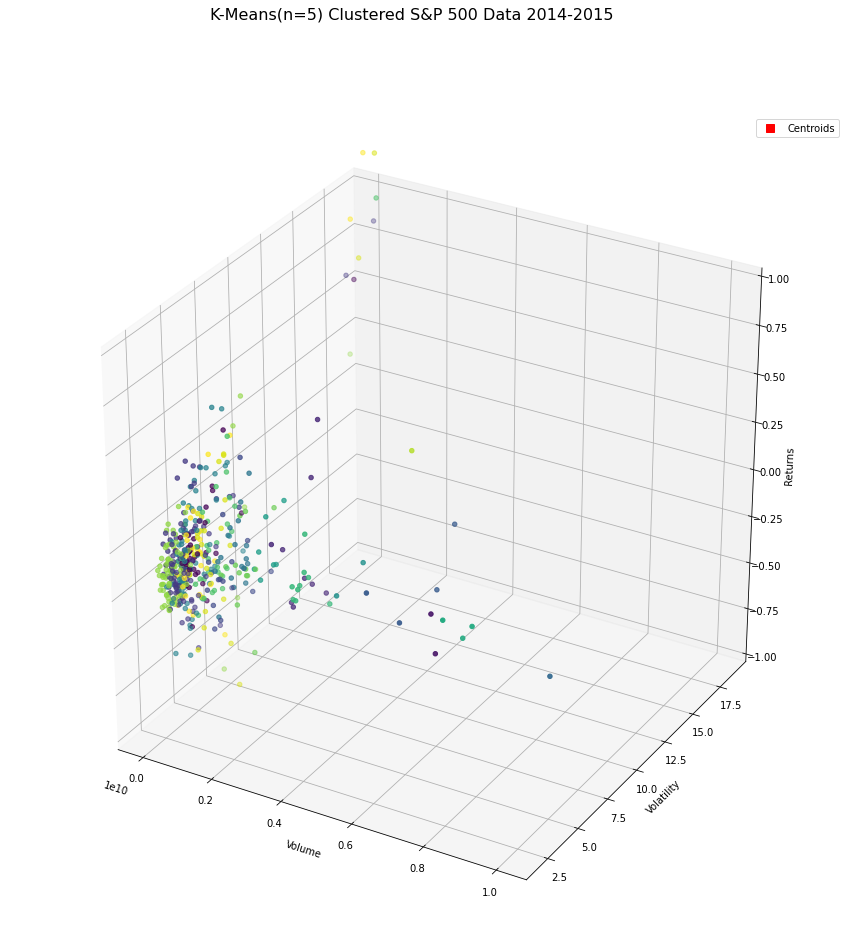

In [156]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle('K-Means(n=5) Clustered S&P 500 Data 2014-2015', fontsize=16)

ax.scatter(z, y, x, c=k_means.labels_, marker='o')
plot(centroids[:,0],centroids[:,1],centroids[:,2],'sr',markersize=8)
ax.legend(['Centroids'])
ax.set_zlim(-1,1)
ax.set_xlabel('Volume')
ax.set_ylabel('Volatility')
ax.set_zlabel('Returns')

plt.show()

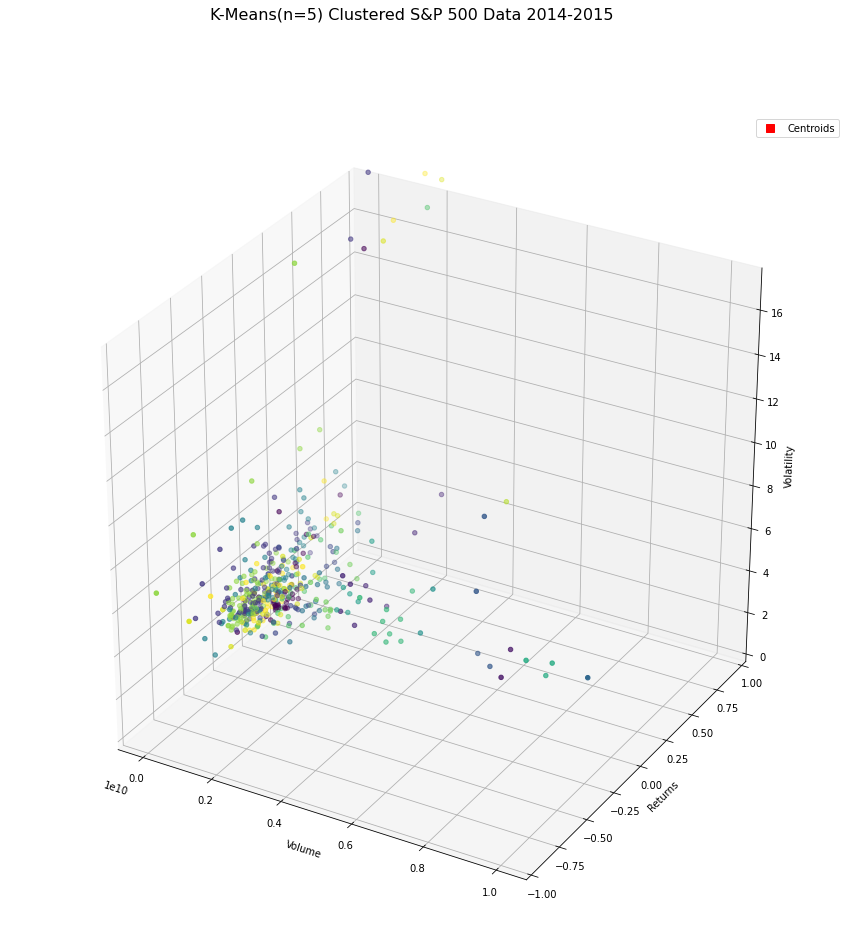

In [157]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle('K-Means(n=5) Clustered S&P 500 Data 2014-2015', fontsize=16)


ax.scatter(z, x, y, c=k_means.labels_, marker='o')
plot(centroids[:,0],centroids[:,1],centroids[:,2],'sr',markersize=8)
ax.legend(['Centroids'])
ax.set_ylim(-1,1)
ax.set_zlim(0,17.5)
ax.set_xlabel('Volume')
ax.set_ylabel('Returns')
ax.set_zlabel('Volatility')

plt.show()

Now that the clustering has been completed, we can create a new dataframe composed on the ticker names and their cluster labels.

In [158]:
tickers = pd.DataFrame(ret_var_vol.index, columns=['Tickers'])
cluster_labels = pd.DataFrame(kmeans.labels_,columns=['Cluster'])
labeled_stocks_3d = pd.concat([tickers, cluster_labels],axis = 1).dropna()
print(labeled_stocks_3d)

    Tickers  Cluster
0       MMM      0.0
1       ABT      4.0
2      ABBV      2.0
3      ABMD      0.0
4       ACN      4.0
..      ...      ...
473     WRB      4.0
474     WAB      0.0
475     WMT      0.0
476     WBA      4.0
477      WM      4.0

[478 rows x 2 columns]


## Clustering Analysis | Returns, Volatility

A second clustering analysis can be done with just the returns and volatility parameters. The results of clustering on imporvement of diversification from this analysis and the three parameter analysis can be later compared.

In [159]:
#generate new dataframe with only two parameters
ret_var = ret_var_vol.drop(['Volume'], axis=1)
print(ret_var)

        Returns Volatility
MMM   -0.192913    2.39916
ABT   -0.179184    2.56219
ABBV -0.0819894    4.43024
ABMD  -0.913676    6.76712
ACN  -0.0988941    2.73051
...         ...        ...
YUM  -0.0580078    3.26328
ZBRA  -0.213887    4.39027
ZBH   -0.195326    3.44852
ZION   0.143904    3.47235
ZTS   -0.439027    3.25018

[499 rows x 2 columns]


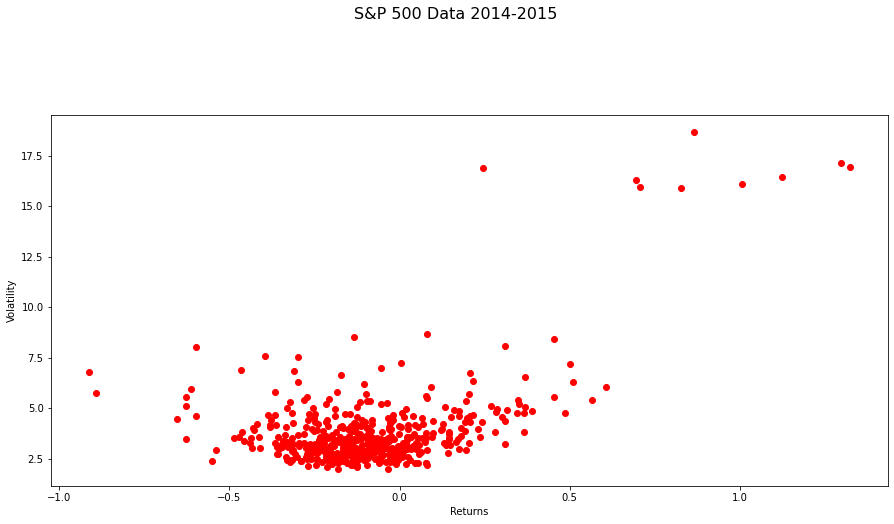

In [160]:
#first plot data 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2 ,1 ,1)
fig.suptitle('S&P 500 Data 2014-2015', fontsize=16)

x = list(ret_var_vol['Returns'].dropna().values)
y = list(ret_var_vol['Volatility'].dropna().values)

#print(x, "\n", len(x))
#print(y, "\n", len(y))
#print(z, "\n", len(z))

ax.scatter(x, y, c='r', marker='o')

ax.set_xlabel('Returns')
ax.set_ylabel('Volatility')

plt.show()

In [0]:
#taken from: https://towardsdatascience.com/machine-learning-for-stock-clustering-using-k-means-algorithm-126bc1ace4e1
#https://www.pythonforfinance.net/2018/02/08/stock-clusters-using-k-means-algorithm-in-python/

from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
import numpy as np
from scipy.cluster.vq import kmeans,vq
import pandas as pd
import pandas_datareader as dr
from math import sqrt
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

#format the data as a numpy array to feed into the K-Means algorithm
#X = np.asarray([np.asarray(ret_var_vol['Returns']),np.asarray(ret_var_vol['Volatility']),np.asarray(ret_var_vol['Volume'])]).T
X = ret_var.dropna().values

Text(0.5, 1.0, 'Elbow curve')

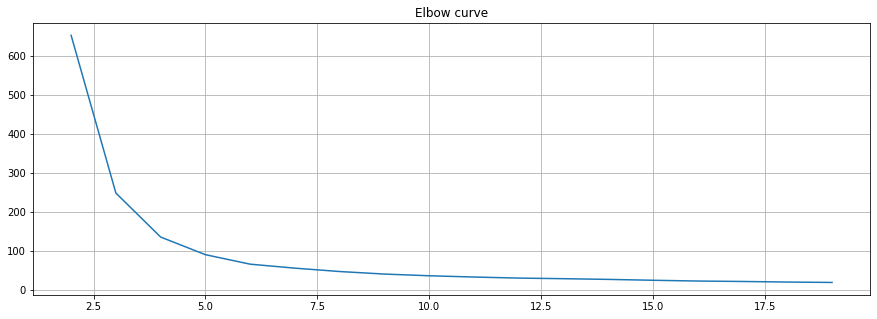

In [162]:
#generate elbow curve
distorsions = []
for k in range(2, 20):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

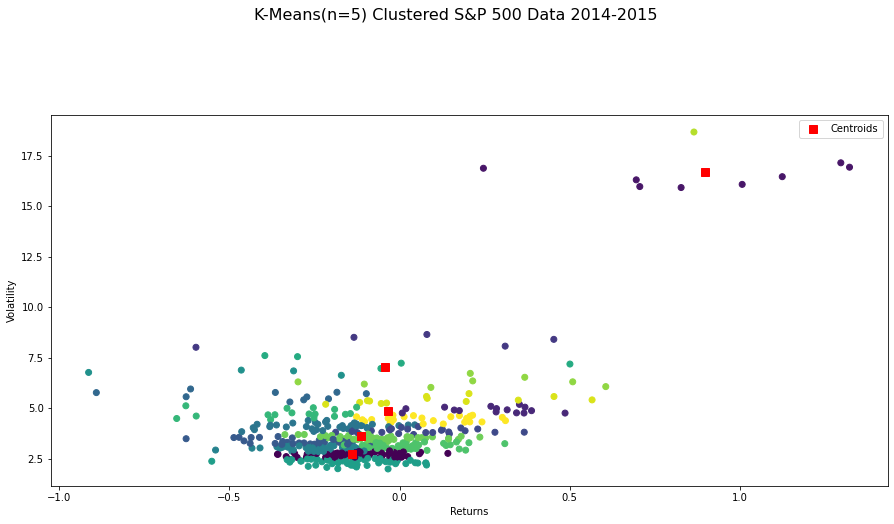

In [163]:
import  pylab as pl

#compute K means with n = 5 and get centroids
kmeans = KMeans(n_clusters = 5)
kmeans.fit(X)
centroids = kmeans.cluster_centers_
#print(centroids)
#print(kmeans.labels_)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2,1,1)
fig.suptitle('K-Means(n=5) Clustered S&P 500 Data 2014-2015', fontsize=16)

ax.scatter(x, y, c=k_means.labels_, marker='o')
plot(centroids[:,0],centroids[:,1],'sr',markersize=8)
ax.legend(['Centroids'])
ax.set_xlabel('Returns')
ax.set_ylabel('Volatility')

plt.show()


In [164]:
tickers = pd.DataFrame(ret_var_vol.index, columns=['Tickers'])
cluster_labels = pd.DataFrame(kmeans.labels_,columns=['Cluster'])
labeled_stocks_2d = pd.concat([tickers, cluster_labels],axis = 1).dropna()
print(labeled_stocks_2d)

    Tickers  Cluster
0       MMM      0.0
1       ABT      0.0
2      ABBV      3.0
3      ABMD      2.0
4       ACN      0.0
..      ...      ...
473     WRB      4.0
474     WAB      3.0
475     WMT      4.0
476     WBA      4.0
477      WM      4.0

[478 rows x 2 columns]


Now we can compare the cluster labeling between the two analyses to see if adding volume as an additional parameter had a signifigant chnage on the clustering results

In [169]:
#print(labeled_stocks_2d)
#print(labeled_stocks_3d)
print(labeled_stocks_2d[labeled_stocks_2d['Cluster'] != labeled_stocks_3d['Cluster']])

    Tickers  Cluster
1       ABT      0.0
2      ABBV      3.0
3      ABMD      2.0
4       ACN      0.0
5      ATVI      4.0
..      ...      ...
470    VIAC      4.0
471     VNO      3.0
472     VMC      4.0
474     WAB      3.0
475     WMT      4.0

[309 rows x 2 columns]
